# Nobel Model

Úlohy:
1. Losovat úmrtí
2. Losovat vakcinaci
3. Ty, kde vakcinace - úmrtí <= 14 dnů => nevakcinovat
4. S pravděpodobností P lidi z bodu 3. necháme zemřít


In [1]:
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
from matplotlib import pyplot as plt
from common import *

import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
sns.set_theme()

## Load data

In [3]:
df_deaths = pd.read_csv(DEATHS_FILE)
df_vacc = pd.read_csv(VACCINATION_FILE)
df_counts = pd.read_csv(COUNTS_FILE)

### Sanity checks

In [4]:
assert len(df_deaths) >= len(df_vacc.drop(columns="poradi_davky").groupby(["tyden", "vek"]).sum()), "Cropping applied?"
assert len(df_deaths["tyden"].unique()) == len(df_vacc["tyden"].unique()), "Weeks are not the same!"
assert len(df_deaths["vek"].unique()) == len(df_vacc["vek"].unique()) == len(df_counts["vek"].unique()), "Age groups are not the same!"

In [5]:
# We will only use first dose
df_vacc = df_vacc[df_vacc.poradi_davky == 1].drop(columns="poradi_davky")

# Convert weeks to timestamps in seconds
df_vacc["tyden"] = pd.to_datetime(df_vacc["tyden"] + "-1", format="%Y-W%W-%w").astype("int64") // 10**9
df_deaths["tyden"] = pd.to_datetime(df_deaths["tyden"] + "-1", format="%Y-W%W-%w").astype("int64") // 10**9

### Preview

In [6]:
df_deaths

,tyden,vek,umrti
0,1609113600,0-29,24
1,1609113600,30-39,27
2,1609113600,40-49,69
3,1609113600,50-59,168
4,1609113600,60-69,428
...,...,...,...
730,1671408000,30-39,23
731,1671408000,40-49,86
732,1671408000,50-59,150
733,1671408000,60-69,342


In [7]:
df_vacc

,tyden,vek,pocet_davek
0,1609113600,0-29,144
1,1609113600,30-39,233
2,1609113600,40-49,338
3,1609113600,50-59,274
4,1609113600,60-69,183
...,...,...,...
2133,1671408000,70-79,2
2135,1671408000,50-59,13
2138,1671408000,0-29,51
2142,1671408000,30-39,19


In [8]:
df_counts

,vek,celkem
0,0-29,3259827
1,30-39,1409650
2,40-49,1735533
3,50-59,1354501
4,60-69,1284689
5,70-79,1037997
6,80-129,441970


## Preparations

In [9]:
TIMEDELTA = timedelta(weeks=2).total_seconds()

In [10]:
def run(p):
    # Data variables
    people = {}
    
    # Variables for metrics
    count_vacc_after_death = 0
    count_vacc_timedelta_death = 0
    x, y11, y12, y21, y22 = {}, {}, {}, {}, {}
    
    # Generate vaccination and death date based on reality for reach person
    for row_counts in df_counts.itertuples():
        # Select rows for age group
        dfs_deaths_sel = df_deaths[df_deaths.vek == row_counts.vek]
        dfs_vacc_sel = df_vacc[df_vacc.vek == row_counts.vek]

        # Append None to the end of the array (= no death & no vaccination classes)
        da = np.append(dfs_deaths_sel.tyden, None)
        va = np.append(dfs_vacc_sel.tyden, None)

        # Append count to the end of the array for assignation with da and va (people with no death/vaccination)
        dp = np.append(dfs_deaths_sel.umrti, row_counts.celkem - dfs_deaths_sel.umrti.sum())
        vp = np.append(dfs_vacc_sel.pocet_davek, row_counts.celkem - dfs_vacc_sel.pocet_davek.sum())

        # Normalize (so that the sum is 1), then randomly choice dates of death/vaccination
        dates_death = np.random.choice(da, row_counts.celkem, p=dp / dp.sum())
        dates_vacc = np.random.choice(va, row_counts.celkem, p=vp / vp.sum())

        # print(f"Dead: {len(dates_death[dates_death != None])}/{dfs_deaths_sel.umrti.sum()}")

        # Assign dates for each person
        for n in range(row_counts.celkem):
            date_death = dates_death[n]
            date_vacc = dates_vacc[n]

            if date_vacc is not None and date_death is not None:
                # Invalid assigment
                if date_vacc > date_death:
                    count_vacc_after_death += 1
                    date_vacc = None

                # Modeled 
                elif date_vacc + TIMEDELTA > date_death:
                    if np.random.random() < p:
                        count_vacc_timedelta_death += 1
                        date_vacc = None

            people.setdefault(row_counts.vek, []).append({"dead": date_death, "vaccinated": date_vacc})

    # print(f"Vakcinováno po úmrtí: {count_vacc_after_death}")
    # print(f"Odebráno pro jev {p=}: {count_vacc_timedelta_death}");
    
    # Create report for graphs based on dates generated above
    for week in np.unique(df_deaths["tyden"]):
        for age, people_age in people.items():
            deaths_vacc = 0
            deaths_norm = 0
            alive_vacc = 0
            alive_norm = 0

            for i in people_age:
                # If selected person won't die in the simulation or die somewhere in the future
                if i["dead"] is None or i["dead"] > week:
                    if i["vaccinated"] is None or i["vaccinated"] > week:
                        alive_norm += 1
                    else:
                        alive_vacc += 1
                
                # If selected person is going to die this week
                elif i["dead"] == week:
                    # There is no need to check for bigger than death, it is filtered before
                    if i["vaccinated"] is None or i["vaccinated"] > week:
                        deaths_norm += 1
                    else:
                        deaths_vacc += 1
            
            # try:
            #     efficacy = 1 - (deaths_vacc / alive_vacc) / (deaths_norm / alive_norm)
            # except ZeroDivisionError:
            #     efficacy = -10

            # Save
            x.setdefault(age, []).append(datetime.fromtimestamp(week))
            y11.setdefault(age, []).append(deaths_vacc)
            y12.setdefault(age, []).append(alive_vacc)
            y21.setdefault(age, []).append(deaths_norm)
            y22.setdefault(age, []).append(alive_norm)
    
    return x, y11, y12, y21, y22, count_vacc_after_death, count_vacc_timedelta_death

## Simulation

In [40]:
P = 0.5

In [41]:
data = process_map(run, [P] * 100, max_workers=os.cpu_count())

  0%|          | 0/100 [00:00<?, ?it/s]

## Visualizations

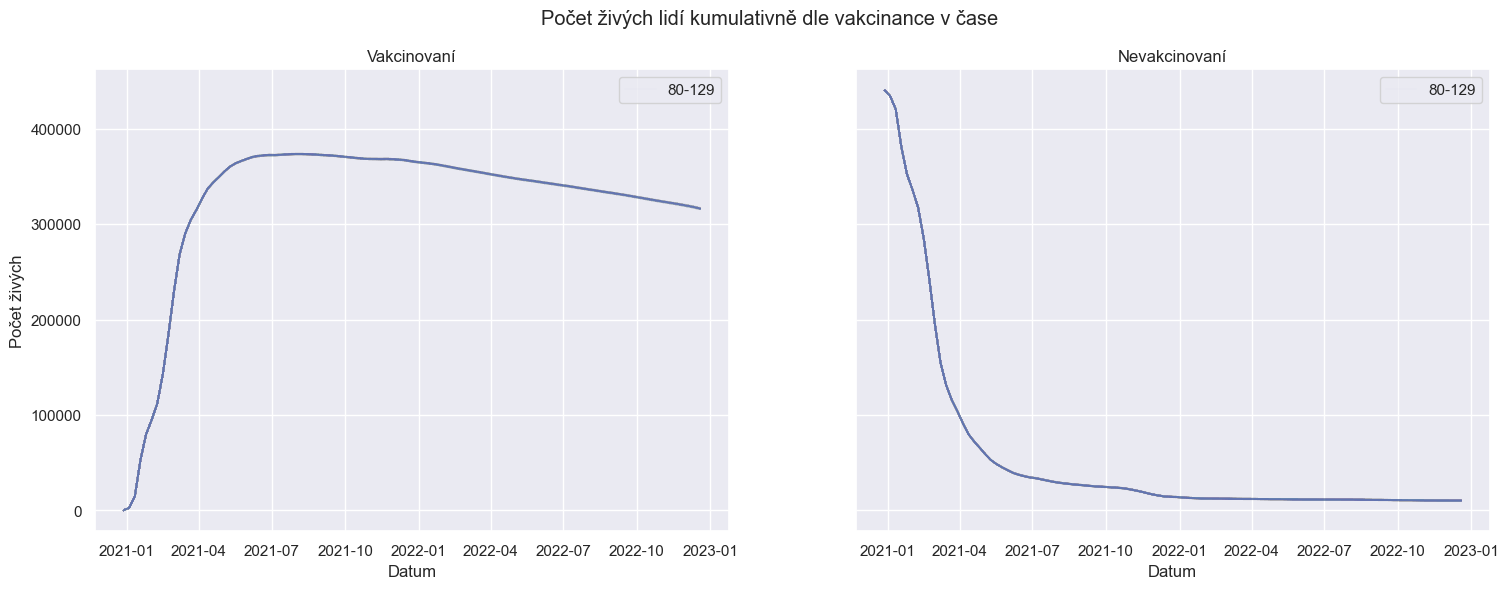

In [42]:
fig, (al, ar) = plt.subplots(1, 2, sharey="row", figsize=(18, 6))
was = set()

for x, y11, y12, y21, y22, errored, removed in data:
    for age in list(y12.keys())[-1:]:
        al.plot(x[age], y12[age], color="b", alpha=0.01, label=age if age not in was else None)
        ar.plot(x[age], y22[age], color="b", alpha=0.01, label=age if age not in was else None)
        was.add(age)

al.set_xlabel("Datum")
ar.set_xlabel("Datum")

al.set_ylabel("Počet živých")

al.set_title("Vakcinovaní")
ar.set_title("Nevakcinovaní")

al.legend()
ar.legend()

fig.suptitle("Počet živých lidí kumulativně dle vakcinance v čase")
plt.savefig(f"result/P_{P}_alive.jpg");

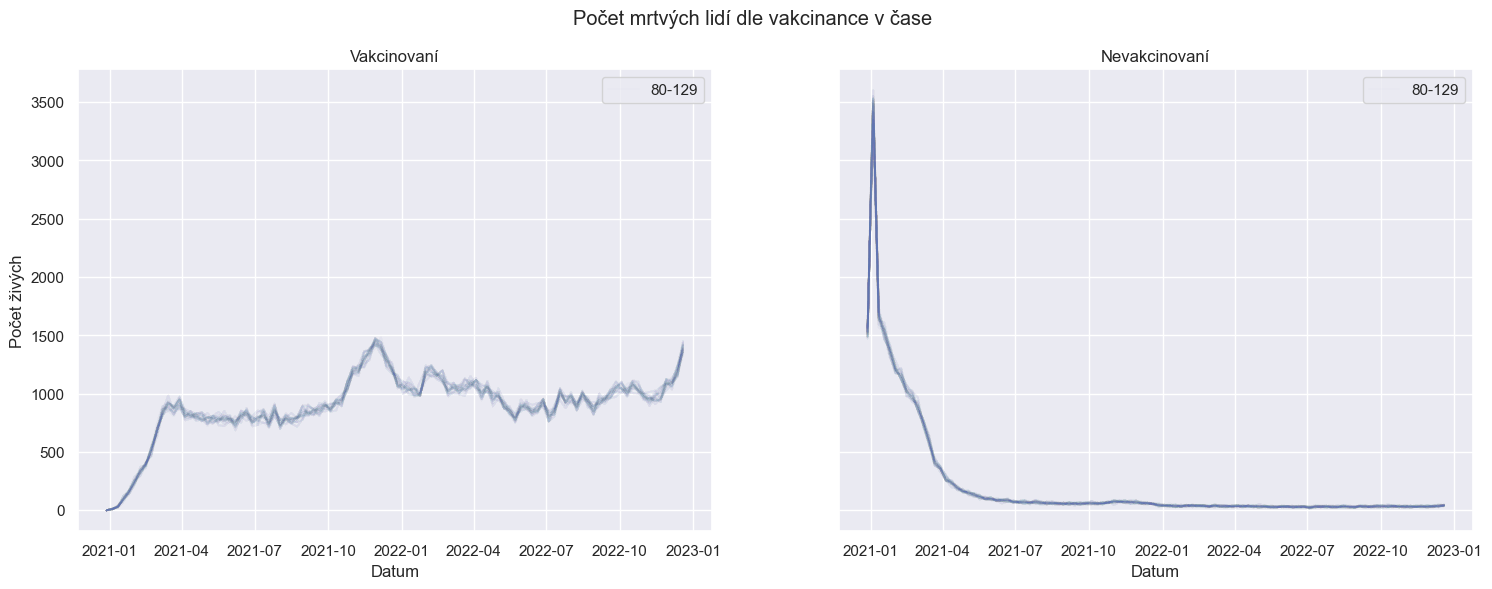

In [43]:
fig, (al, ar) = plt.subplots(1, 2, sharey="row", figsize=(18, 6))
was = set()

for x, y11, y12, y21, y22, errored, removed in data:
    for age in list(y12.keys())[-1:]:
        al.plot(x[age], y11[age], color="b", alpha=0.01, label=age if age not in was else None)
        ar.plot(x[age], y21[age], color="b", alpha=0.01, label=age if age not in was else None)
        was.add(age)

al.set_xlabel("Datum")
ar.set_xlabel("Datum")

al.set_ylabel("Počet živých")

al.set_title("Vakcinovaní")
ar.set_title("Nevakcinovaní")

al.legend()
ar.legend()

fig.suptitle("Počet mrtvých lidí dle vakcinance v čase")
plt.savefig(f"result/P_{P}_dead.jpg");

### Účinnost

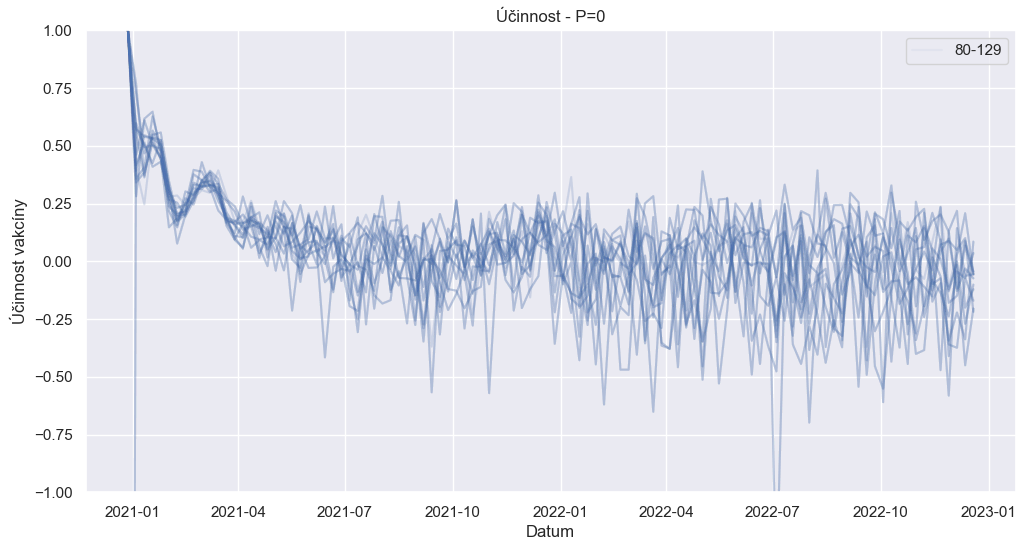

In [44]:
plt.figure(figsize=(12, 6))
was = set()

for x, y11, y12, y21, y22, errored, removed in data:
    for age in list(y12.keys())[-1:]:
        plt.plot(
            x[age], 
            1 - (np.array(y11[age]) / np.array(y12[age])) / (np.array(y21[age]) / np.array(y22[age])),
            alpha=0.05,
            color="b",
            label=age if age not in was else None
        )
        was.add(age)

plt.ylabel("Účinnost vakcíny")
plt.xlabel("Datum")
plt.title(f"Účinnost - P={0}")
plt.ylim(-1, 1)
plt.legend()
plt.savefig(f"result/P_{P}_efficacy.jpg");